In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image

from datetime import datetime
from tensorflow import keras

from tensorflow.python.framework import ops


In [3]:
%load_ext tensorboard

In [4]:
from google.colab import drive

In [6]:
drive.mount('check')

Mounted at check


In [7]:
root_dir='check/MyDrive/Colab Notebooks/'
os.chdir(root_dir)

In [9]:
train_data_dir="above20_train/"

data=list()
count=0
for i in os.listdir(train_data_dir):
    for image in os.listdir(train_data_dir+i):
        img=Image.open(train_data_dir+i+"/"+image)
        data.append((np.array(img),i))
        count+=1


In [10]:
len(data)

620

In [11]:
train_data=pd.DataFrame(data,columns=["image","name"])

In [12]:
train_data.shape

(620, 2)

(60, 60, 3)


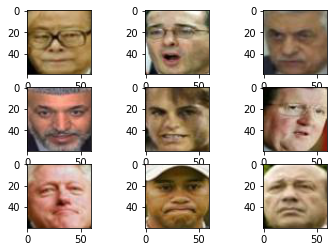

In [13]:
idx = 34
row = train_data.iloc[idx, :]
print(row.image.shape)
for i in range(9):
    row = train_data.iloc[np.random.randint(0, len(train_data)), :]
    plt.subplot(3,3,i+1)
    plt.imshow(row.image)
plt.show()

In [14]:
test_data_dir="above20_test/"
count=0
data_1 = []
for i in os.listdir(test_data_dir):
    for image in os.listdir(test_data_dir+i)[:5]:
        img=Image.open(test_data_dir+i+"/"+image)
        data_1.append((np.array(img),i))
        count+=1
val_data = pd.DataFrame(data_1, columns=["image", "name"])
print("Test size: ", len(val_data))

Test size:  310


In [15]:
len(data_1)

310

Preprocessing data

In [16]:
le = LabelEncoder()
le.fit(train_data["name"].values)

LabelEncoder()

In [17]:
x_train = list(train_data.image.values)
x_train = np.array(x_train)
x_train = x_train/255
print(x_train.shape)

y_train = le.transform(train_data["name"].values)
print(y_train.shape)

(620, 60, 60, 3)
(620,)


In [18]:
x_val = list(val_data.image.values)
x_val = np.array(x_val)
x_val = x_val/255
print(x_val.shape)

y_val = le.transform(val_data["name"].values)
print(y_val.shape)

(310, 60, 60, 3)
(310,)


In [19]:
people_num = len(np.unique(y_train))
people_num

62

In [20]:
del data
del data_1

Preaparing and fitting model

In [21]:
# calculate triplet loss, the anchor output, positive output and negative output are stored in y_pred sequentially and in that order
def triplet_loss(y_true, y_pred, alpha = 0.6):
    total_length = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_length)], \
        y_pred[:,int(1/3*total_length):int(2/3*total_length)], y_pred[:,int(2/3*total_length):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [22]:
#this function generates triplets for each image in training data, num_same and num_diff define the number of triplets that are genrated for each image.
def generate_triplets(x, y, num_same = 4, num_diff = 4):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
        if i%100==0:
          print(i)
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
    return anchor_images, same_images, diff_images

In [26]:
anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 3, num_diff=3)

0
100
200
300
400
500
600


In [27]:
anchor_images.shape

(5580, 60, 60, 3)

In [28]:
print('\n')
print(anchor_images.shape, same_images.shape, diff_images.shape)



(5580, 60, 60, 3) (5580, 60, 60, 3) (5580, 60, 60, 3)


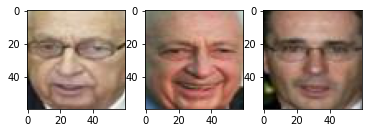

In [29]:
#viewing a random triplet
idx = 54

plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])
plt.show()

In [30]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [267]:
#function to return model
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1,padding='same'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1,padding='same'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=2, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1,padding='same'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=2, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1,padding='same'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [268]:
img_size=60

In [269]:
ops.reset_default_graph()
#concatenate anchor, positive and negative data and send to network
anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],
                                            axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0

In [190]:
weight_dir = "weight_tripletloss_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [191]:
Y_dummy = np.empty((anchor_images.shape[0],1))
#training model
with tf.device('/device:GPU:0'):
  model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=250, callbacks=[checkpoint,tensorboard_callback]) 

Epoch 1/250
44/44 [==============================] - 7s 122ms/step - loss: 72.7461
Epoch 2/250
44/44 [==============================] - 5s 104ms/step - loss: 57.9189
Epoch 3/250
44/44 [==============================] - 5s 103ms/step - loss: 41.9397
Epoch 4/250
44/44 [==============================] - 5s 103ms/step - loss: 30.8627
Epoch 5/250
44/44 [==============================] - 5s 104ms/step - loss: 24.6510
Epoch 6/250
44/44 [==============================] - 5s 103ms/step - loss: 18.7141
Epoch 7/250
44/44 [==============================] - 4s 102ms/step - loss: 13.8614
Epoch 8/250
44/44 [==============================] - 4s 102ms/step - loss: 14.6634
Epoch 9/250
44/44 [==============================] - 4s 101ms/step - loss: 10.4380
Epoch 10/250
44/44 [==============================] - 4s 101ms/step - loss: 6.8241
Epoch 11/250
44/44 [==============================] - 4s 101ms/step - loss: 8.7222
Epoch 12/250
44/44 [==============================] - 5s 103ms/step - loss: 5.8775
Epoc

KeyboardInterrupt: ignored

In [298]:
model.save('model2904_10_more_depth/')

INFO:tensorflow:Assets written to: model2904_10_more_depth/assets


In [337]:
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

In [338]:
pred = anchor_model.predict(x_train)
pred.shape

(620, 128)

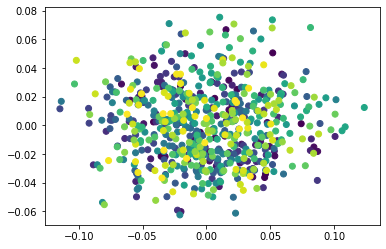

In [339]:
#visualizing the clusters formed
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)
plt.show()

In [340]:
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [341]:
def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [342]:
name_dict = {}
for i in set(train_data["name"].values):
    z = train_data[train_data["name"] == i].image
    img = np.array(list(z))/255
    enc = np.zeros((1,128))
    for j in range(len(z)):
        enc += encode_image(anchor_model,img[j])

    enc = enc/len(z)
    name_dict[i] = enc

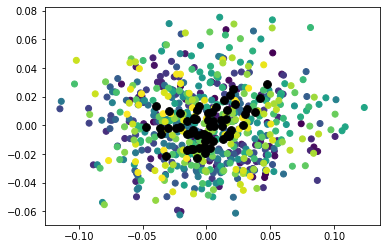

In [343]:
pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

for val in name_dict.values():
    point = pca.transform(val)
    plt.scatter(point[0,0], point[0,1], s = [60], c='black')
plt.savefig("validation.png")
plt.show()

In [344]:
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

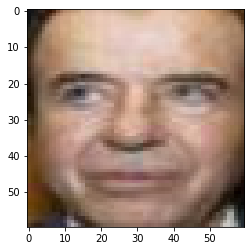

Predicted name: Carlos_Menem  with distance 0.04224860931908649
Actual pred:  ['Carlos_Menem']


In [345]:
idx = 70
img = x_train[idx]
plt.imshow(img)
plt.show()
n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",n ," with distance", d)
print("Actual pred: ", le.inverse_transform(y_train[idx:idx+1]))

Using K Means

In [346]:
pred_x_train = anchor_model.predict(x_train)

In [347]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(pred_x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [349]:
pred_x_val = anchor_model.predict(x_val)
pred = neigh.predict(pred_x_val)

print(np.sum(pred == y_val)/len(pred))

0.06451612903225806


Checking validation accuracy of all tried models

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
model_dir='models/'
k_values=[1,3,5,7,9]

for model in os.listdir(model_dir):
  curr_model=tf.keras.models.load_model(model_dir+model,custom_objects={"triplet_loss":triplet_loss})
  pred_x_train=curr_model.layers[3](x_train)
  print(model)
  print(curr_model.layers[3].summary())
  print('k\t','Accuracy')
  for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(pred_x_train, y_train)
    pred_x_val=curr_model.layers[3](x_val)
    pred=neigh.predict(pred_x_val)
    print(k,np.sum(pred == y_val)/len(pred),sep='\t')

model2904
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)      

Checking test accuracy for model with best validation accuracy <br>
On model2904_9_no_dropout_with_pool_with_less_triplet with k=9, we get validation accuracy of 58.54%

In [57]:
test_data_dir="above20_test/"
count=0
data_1 = []
for i in os.listdir(test_data_dir):
    for image in os.listdir(test_data_dir+i)[5:]:
        img=Image.open(test_data_dir+i+"/"+image)
        data_1.append((np.array(img),i))
        count+=1
test_data = pd.DataFrame(data_1, columns=["image", "name"])
print("Test size: ", len(test_data))

Test size:  310


In [58]:
x_test = list(test_data.image.values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(test_data["name"].values)
print(y_test.shape)

(310, 60, 60, 3)
(310,)


In [59]:
best_model=tf.keras.models.load_model(model_dir+"model2904_9_no_dropout_with_pool_with_less_triplet",custom_objects={"triplet_loss":triplet_loss})

In [61]:
pred_x_train=best_model.layers[3](x_train)
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(pred_x_train, y_train)
pred_x_test=best_model.layers[3](x_test)
pred=neigh.predict(pred_x_test)
print("Accuracy",np.sum(pred == y_test)/len(pred),sep='\t')

Accuracy	0.613225806451613


In [62]:
best_model.layers[3].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0

In [63]:
drive.flush_and_unmount()